In [61]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

In [62]:
from utils import *
from data import *
from models import *
from train import *

In [63]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [65]:
data_mit = import_mit_data()

In [66]:
beats = []
freq = 360

for i,patient in tqdm(enumerate(data_mit), total=len(data_mit)):
    for waveform, label in patient:
        rpeaks = wfdb.processing.xqrs_detect(waveform, fs=freq, verbose=False)

        for peak in rpeaks:
            if peak >= freq/2 and peak < len(waveform) - freq/2:
                partial_wave = waveform[peak-freq//2:peak+freq//2]
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                beats.append((partial_wave, label, i)) 

100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


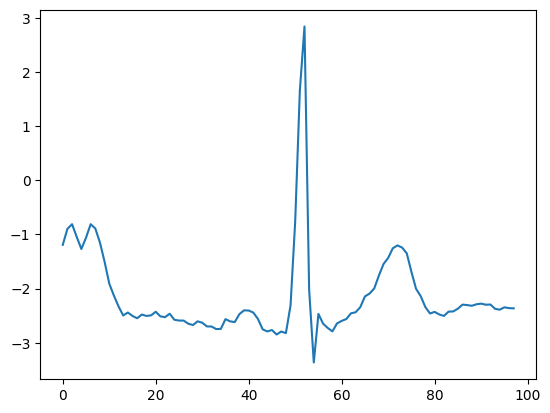

In [67]:
def plotbeat(x):
    if type(x) is tuple:
        plt.plot(x[0])
    else:
        plt.plot(x)

plotbeat(beats[0])

# Dataset

In [68]:
labels = list(set([x[1] for x in beats]))
label_map = {label:i for i,label in enumerate(labels)}

In [69]:
class BeatDataset(Dataset):
    def __init__(self, data, device, label_map, specify_patient=None):
        self.data = []

        for waveform, label, patient in tqdm(data):
            if specify_patient:
                if patient != specify_patient:
                    continue
                

            ## Z-score Normalisation
            waveform = (waveform - waveform.mean()) / waveform.std()

            self.data.append((
                torch.tensor(waveform, device=device, dtype=torch.float32),
                torch.tensor(label_map[label], device=device),
                patient
            ))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        waveform, label, patient = self.data[idx]

        return waveform, label
    
beat_dataset = BeatDataset(beats, device, label_map)
beat_dataloader = DataLoader(beat_dataset, batch_size=128, shuffle=True)

100%|██████████| 76851/76851 [00:06<00:00, 11440.68it/s]


In [70]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=embedding_dim, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        _, hidden = self.lstm2(x)

        # return lstm_out[:,-1,:]
        return hidden
    
class Decoder(nn.Module):
    def __init__(self, seq_len=98, embedding_dim=32):
        super().__init__()

        self.seq_len = seq_len
        
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        # x = x.unsqueeze(1).repeat(1,self.seq_len,1)
        x,_ = self.lstm1(torch.zeros([x[0].shape[1], self.seq_len, x[0].shape[2]], device=x[0].device), x)
        x = self.dropout(x)
        x,_ = self.lstm2(x)
        x = self.output_layer(x)

        return x.squeeze(2)

class AEModel(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()

        self.encoder = Encoder(embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AEModel(embedding_dim=32).to(device)
# model.load_state_dict(torch.load('autoencoder.pt'))

In [71]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

losses = []

In [72]:
for epoch in range(10000):
    model.train()

    for i,batch in enumerate(beat_dataloader, 0):

        optimizer.zero_grad()

        seq, label = batch

        seq_pred = model.forward(seq)

        loss = criterion(seq, seq_pred)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.)
        optimizer.step()

    if epoch % 10 == 0:
        model.eval()

        totalloss = 0.

        with torch.no_grad():
            for i,batch in enumerate(beat_dataloader, 0):
                seq, label = batch

                seq_pred = model.forward(seq)

                loss = criterion(seq, seq_pred)

                totalloss += loss.item()

        print(f'epoch {epoch}, loss {totalloss}')
        losses.append(totalloss)

    if epoch % 100 == 0:
        torch.save(model.state_dict(), 'autoencoder.pt')

epoch 0, loss 408.72707653045654
epoch 10, loss 190.91562044620514
epoch 20, loss 102.91941507160664
epoch 30, loss 78.32297296822071
epoch 40, loss 72.80006041377783
epoch 50, loss 48.87004900723696
epoch 60, loss 50.44672571122646
epoch 70, loss 42.02945065125823
epoch 80, loss 35.97989794239402
epoch 90, loss 34.92661710828543
epoch 100, loss 32.40993409231305
epoch 110, loss 29.929941032081842
epoch 120, loss 28.13510636612773
epoch 130, loss 26.373012417927384
epoch 140, loss 23.687589958310127
epoch 150, loss 25.14092205837369
epoch 160, loss 24.29693783633411
epoch 170, loss 27.1938245780766
epoch 180, loss 23.673396347090602
epoch 190, loss 22.052726078778505
epoch 200, loss 21.95842389948666
epoch 210, loss 22.442779503762722
epoch 220, loss 20.323004549369216
epoch 230, loss 21.82434180006385
epoch 240, loss 19.86348621174693
epoch 250, loss 19.70172635279596
epoch 260, loss 21.98808266967535
epoch 270, loss 20.71210964396596
epoch 280, loss 18.77197632007301
epoch 290, loss 

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'autoencoder.pt')

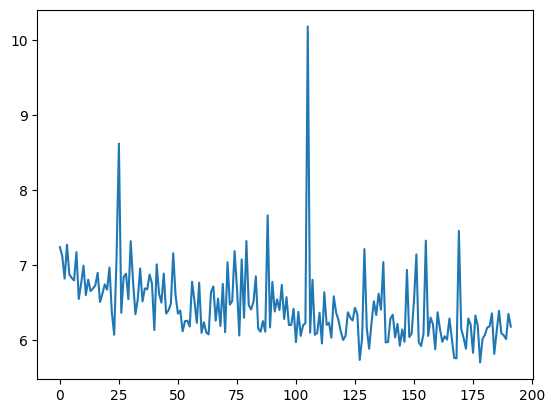

In [74]:
# plt.plot([np.log(x) for x in losses])
plt.plot(losses[150:])

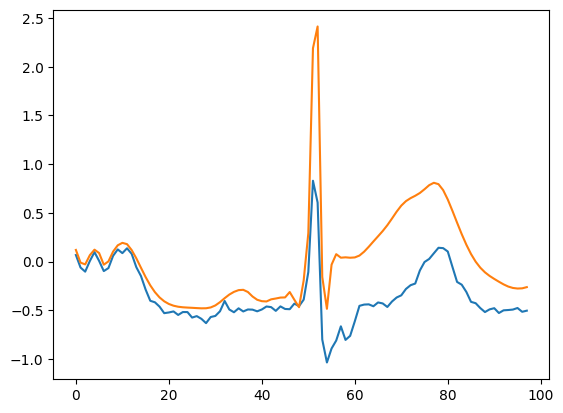

In [79]:
# i = 12425
i=11422

seq, label, _ = beats[i]
seq = torch.tensor(seq, dtype=torch.float32, device=device)
seq = seq.reshape((1,98))
model.eval()
seq_pred = model.forward(seq)

plt.plot(seq.detach().cpu().numpy().reshape(-1))
plt.plot(seq_pred.detach().cpu().numpy().reshape(-1))


# Distribution Difference

In [ ]:
users = [{key:[] for key in label_map.keys()} for i in range(48)]

for beat in beats:
    users[beat[2]][beat[1]].append(beat[0])

In [ ]:
label_map

{'L': 0, 'R': 1, 'N': 2, 'V': 3, 'P': 4}

In [ ]:
[len(x) for x in users[12].values()]

[0, 0, 1151, 0, 0]

In [ ]:
def encode(beats):
    values = np.stack(beats, axis=1).reshape((-1, 98))
    seq = torch.tensor(values, dtype=torch.float32, device=device)
    model.eval()
    with torch.no_grad():
        encoded = model.encoder.forward(seq)
    encoded = torch.concat(encoded, dim=2).squeeze(0)
    return encoded

def relative_entropy(beats_1, beats_2):
    encode_1 = encode(beats_1).detach().cpu().numpy()
    encode_2 = encode(beats_2).detach().cpu().numpy()

    kde_D1 = KernelDensity(bandwidth=1.0, kernel='gaussian').fit(encode_1)
    kde_D2 = KernelDensity(bandwidth=1.0, kernel='gaussian').fit(encode_2)

    # X = np.vstack([encode_1, encode_2])
    X = np.vstack([encode_1[:min(len(encode_1), len(encode_2))], encode_2[:min(len(encode_1), len(encode_2))]])
    # X = np.vstack([random.sample(encode_1, min(len(encode_1), len(encode_2))), random.sample(encode_2, min(len(encode_1), len(encode_2)))])

    log_prob_D1 = kde_D1.score_samples(X)
    log_prob_D2 = kde_D2.score_samples(X)

    prob_D1 = np.exp(log_prob_D1)
    prob_D2 = np.exp(log_prob_D2)

    # Calculate the KL divergence
    kl_divergence = jensenshannon(prob_D1, prob_D2)

    # print(kl_divergence)

    return kl_divergence

group_1 = users[9]['N'][:1000]
# group_2 = users[9]['N'][1000:]
group_2 = users[12]['N'][:1000]
# group_2 = users[20]['R'][:1000]

relative_entropy(group_1, group_2)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
category = 'N'

groups = []
for patient in users:
    if len(patient[category]) > 1000:
        groups.append(patient[category])

len(groups)

31

In [ ]:
avg_intergroup = 0
for group in groups:
    avg_intergroup += relative_entropy(group[:len(group)//2], group[len(group)//2:])

avg_intergroup /= len(groups)

avg_betweengroup = 0
count = 0
for i in tqdm(range(len(groups))):
    for j in range(i+1, len(groups)):
        avg_betweengroup += relative_entropy(groups[i], groups[j])
        count += 1

avg_betweengroup /= count

100%|██████████| 31/31 [04:39<00:00,  9.02s/it]


In [ ]:
print(avg_intergroup, avg_betweengroup)

0.13391881274500528 0.5520462977884323


In [ ]:
len(groups)

31

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  1.,  1.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  2.,
         1.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,
         1.,  0.,  0.,  1.,  0.,  2.,  2.,  0.,  2.,  0.,  1.,  2.,  1.,
         5.,  0.,  1.,  6.,  5.,  3.,  6., 17., 12., 16., 34., 34., 36.,
        54., 66., 63., 75., 59., 68., 58., 73., 36., 29., 31., 24., 17.,
        15., 12., 16., 19., 10.,  8.,  6., 12.,  8.,  3.,  2.,  2.,  1.,
         0.,  2.,  5.,  0.,  1.,  1.,  3.,  2.,  1.]),
 array([-0.97480834, -0.95593017, -0.93705195, -0.91817379, -0.89929557,
        -0.88041741, -0.86153919, -0.84266102, -0.8237828 , -0.80490464,
        -0.78602642, -0.76714826, -0.74827003, -0.72939187, -0.71051365,
        -0.69163549, -0.67275727, -0.65387911, -0.63500094, -0.61612272,
        -0.59724456, -0.57836634, -0.55948818, -0.54060996, -0.52173179,
        -0.50285357, -0.48397541, -0.46509722, -0.44621903, -0.427340

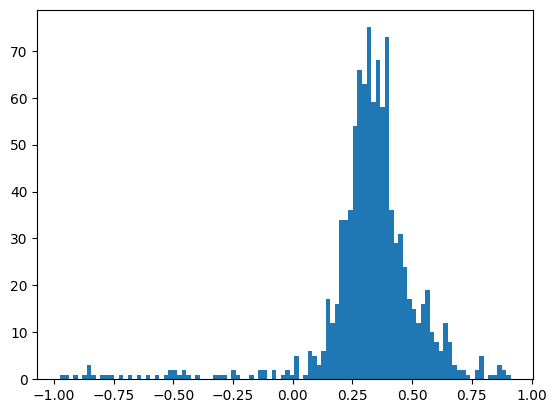

In [ ]:
plt.hist(y[:,9], bins=100)